# Multi-sample Pipeline: analyzing snATAC-seq data of human colon samples

## Introduction

In this tutorial, we will perform integrative analysis of snATAC-seq data of colon sample from multiple donors. 

In [1]:
import snapatac2 as snap
import numpy as np

snap.__version__

'2.5.0dev2'

Download the example dataset.

In [2]:
files = snap.datasets.colon()
files

[('colon_transverse_SM-A9HOW',
  PosixPath('/home/zhangkaiLab/zhangkai33/.cache/snapatac2/colon_transverse.tar.untar/colon_transverse_SM-A9HOW_rep1_fragments.bed.gz')),
 ('colon_transverse_SM-A9VP4',
  PosixPath('/home/zhangkaiLab/zhangkai33/.cache/snapatac2/colon_transverse.tar.untar/colon_transverse_SM-A9VP4_rep1_fragments.bed.gz')),
 ('colon_transverse_SM-BZ2ZS',
  PosixPath('/home/zhangkaiLab/zhangkai33/.cache/snapatac2/colon_transverse.tar.untar/colon_transverse_SM-BZ2ZS_rep1_fragments.bed.gz')),
 ('colon_transverse_SM-CSSDA',
  PosixPath('/home/zhangkaiLab/zhangkai33/.cache/snapatac2/colon_transverse.tar.untar/colon_transverse_SM-CSSDA_rep1_fragments.bed.gz')),
 ('colon_transverse_SM-ACCQ1',
  PosixPath('/home/zhangkaiLab/zhangkai33/.cache/snapatac2/colon_transverse.tar.untar/colon_transverse_SM-ACCQ1_rep1_fragments.bed.gz'))]

First we use `pp.import_data` to import the fragment files.

In [3]:
%%time
adatas = snap.pp.import_data(
    [fl for _, fl in files],
    file=[name + '.h5ad' for name, _ in files],
    chrom_sizes=snap.genome.hg38,
    min_num_fragments=1000,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.91s/it]

CPU times: user 58.6 ms, sys: 31.1 ms, total: 89.7 ms
Wall time: 40.3 s


We then follow the standard procedures to add tile matrices, select features, and identify doublets. Note these functions can take either a single AnnData object or a list of AnnData objects.

In [4]:
%%time
snap.metrics.tsse(adatas, snap.genome.hg38)
snap.pp.filter_cells(adatas, min_tsse=7)
snap.pp.add_tile_matrix(adatas, bin_size=5000)
snap.pp.select_features(adatas, n_features=50000)
snap.pp.scrublet(adatas)
snap.pp.filter_doublets(adatas)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.19s/it]

CPU times: user 566 ms, sys: 96.3 ms, total: 662 ms
Wall time: 3min


## Creating AnnDataSet object

We then create an `AnnDataSet` object which contains links to individual data. The data are not loaded into memory so it can scale to very large dataset.

In [5]:
%%time
data = snap.AnnDataSet(
    adatas=[(name, adata) for (name, _), adata in zip(files, adatas)],
    filename="colon.h5ads"
)
data

CPU times: user 357 ms, sys: 74.8 ms, total: 432 ms
Wall time: 689 ms


AnnDataSet object with n_obs x n_vars = 41785 x 606219 backed at 'colon.h5ads'
contains 5 AnnData objects with keys: 'colon_transverse_SM-A9HOW', 'colon_transverse_SM-A9VP4', 'colon_transverse_SM-BZ2ZS', 'colon_transverse_SM-CSSDA', 'colon_transverse_SM-ACCQ1'
    obs: 'sample'
    uns: 'reference_sequences', 'AnnDataSet'

When merging multiple h5ad files, SnapATAC2 automatically adds a column to `.obs['sample']`, indicating the origin of the cells. After merging, `.obs_names` are no longer garanteed to be unique, as some barcodes may be shared across experiments.

In [6]:
print(f'Number of cells: {data.n_obs}')
print(f'Number of unique barcodes: {np.unique(data.obs_names).size}')

Number of cells: 41785
Number of unique barcodes: 40630


From the example provided, it's evident that the number of unique barcodes is fewer than the total cell count in the merged dataset. This discrepancy arises from barcode collisions across different samples. To address this, we can generate unique cell IDs by concatenating `.obs_names` with the sample IDs found in `.obs['sample']`.

In [7]:
unique_cell_ids = [sa + ':' + bc for sa, bc in zip(data.obs['sample'], data.obs_names)]
data.obs_names = unique_cell_ids
assert data.n_obs == np.unique(data.obs_names).size

In [8]:
snap.pp.select_features(data, n_features=50000)

2023-10-08 13:26:56 - INFO - Selected 50000 features.


In [9]:
%%time
snap.tl.spectral(data)

CPU times: user 52.1 s, sys: 1min 38s, total: 2min 30s
Wall time: 33.9 s


We next perform UMAP embedding and visualize the result.

In [10]:
%%time
snap.tl.umap(data)

/storage/zhangkaiLab/zhangkai33/software/micromamba/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/storage/zhangkaiLab/zhangkai33/software/micromamba/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


CPU times: user 57.6 s, sys: 8.24 s, total: 1min 5s
Wall time: 1min 3s


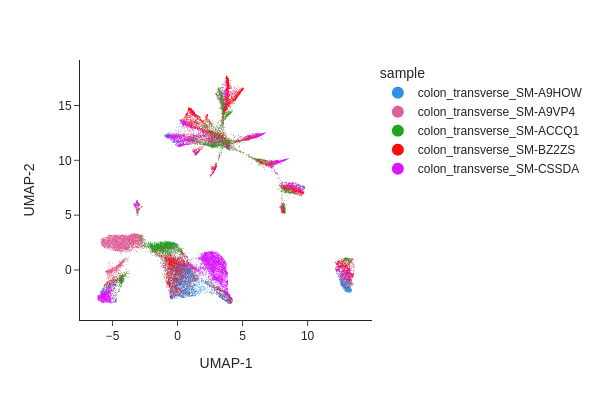

In [11]:
snap.pl.umap(data, color="sample", interactive=False)

## Batch correction

From the UMAP plot above we can clearly see some donor/individual specific effects. Although these donor differences are interesting to study on their own, it obscures the clustering procedure for identifying shared cell states across individuals.

Here we apply two different approaches, Harmony and modified MNNCorrect, to remove donor specific differences.

In [12]:
%%time
snap.pp.mnc_correct(data, batch="sample")
snap.pp.harmony(data, batch="sample", max_iter_harmony=20)

2023-10-08 13:31:17,448 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-10-08 13:31:17 - INFO - Computing initial centroids with sklearn.KMeans...
2023-10-08 13:31:30,701 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-10-08 13:31:30 - INFO - sklearn.KMeans initialization complete.
2023-10-08 13:31:30,985 - harmonypy - INFO - Iteration 1 of 20
2023-10-08 13:31:30 - INFO - Iteration 1 of 20
2023-10-08 13:31:40,610 - harmonypy - INFO - Iteration 2 of 20
2023-10-08 13:31:40 - INFO - Iteration 2 of 20
2023-10-08 13:31:49,806 - harmonypy - INFO - Iteration 3 of 20
2023-10-08 13:31:49 - INFO - Iteration 3 of 20
2023-10-08 13:31:55,125 - harmonypy - INFO - Converged after 3 iterations
2023-10-08 13:31:55 - INFO - Converged after 3 iterations


CPU times: user 13min 14s, sys: 1min 39s, total: 14min 54s
Wall time: 2min 55s


Visualizing the result of MNNCorrect.

/storage/zhangkaiLab/zhangkai33/software/micromamba/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



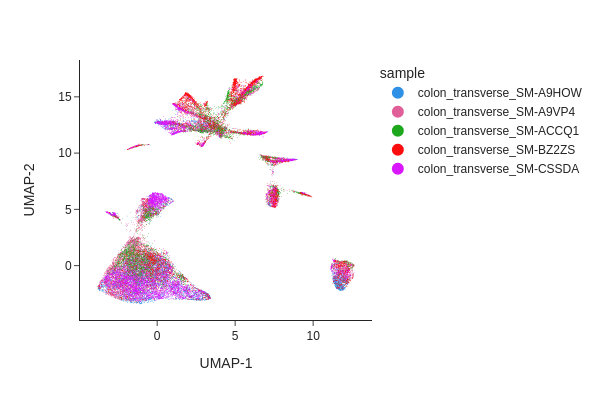

In [13]:
snap.tl.umap(data, use_rep="X_spectral_mnn")
snap.pl.umap(data, color="sample", interactive=False)

Visualize the result of Harmony.

/storage/zhangkaiLab/zhangkai33/software/micromamba/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



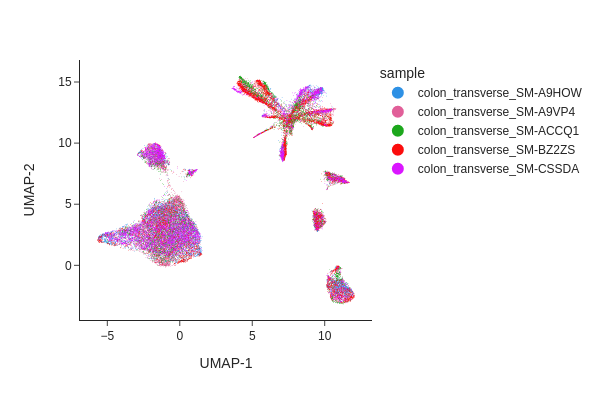

In [14]:
snap.tl.umap(data, use_rep="X_spectral_harmony")
snap.pl.umap(data, color="sample", interactive=False)

Both methods have effectively eliminated the unwanted effects, as can be seen. While we do not offer a recommendation for one method over the other, it's worth noting that Harmony's algorithm sometimes may significantly alter the underlying topology and generate artificial clusters.

## Clustering

In [15]:
snap.pp.knn(data, use_rep="X_spectral_harmony")

In [16]:
snap.tl.leiden(data)

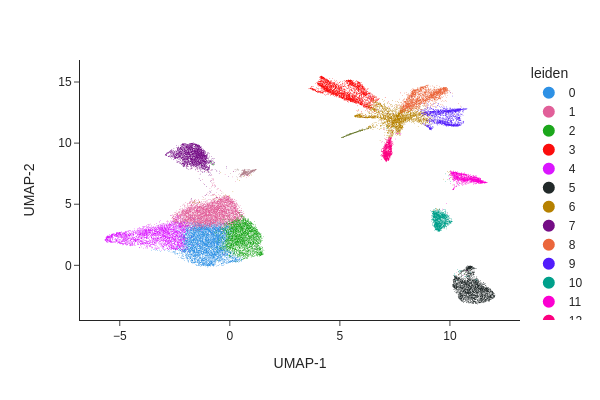

In [17]:
snap.pl.umap(data, color="leiden", interactive=False)

## Peak calling

In [18]:
%%time
snap.tl.macs3(data, groupby='leiden', replicate='sample')

2023-10-08 13:33:24 - INFO - Exporting fragments...
2023-10-08 13:35:29 - INFO - Calling peaks...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [11:17<00:00, 45.17s/it]


CPU times: user 7min 37s, sys: 8.46 s, total: 7min 46s
Wall time: 13min 23s


In [19]:
merged_peaks = snap.tl.merge_peaks(data.uns['macs3'], chrom_sizes=snap.genome.hg38)
merged_peaks.shape

(69760, 16)

## AnnDataSet object IO

Just like the AnnData object, AnnDataSet object is synchronized with the content of the HDF5 file. Therefore, there is no need to manually save the result. After the analysis is finished, simply close the file by:

In [20]:
data.close()
data

Closed AnnDataSet object

The AnnDataSet object is stored as a standard h5ad file, in which the links to individual anndata file was saved in `uns['AnnDataSet']` and can be reopened by `snap.read_dataset`.

In [21]:
data = snap.read_dataset("colon.h5ads")
data

AnnDataSet object with n_obs x n_vars = 41785 x 606219 backed at 'colon.h5ads'
contains 5 AnnData objects with keys: 'colon_transverse_SM-A9HOW', 'colon_transverse_SM-A9VP4', 'colon_transverse_SM-BZ2ZS', 'colon_transverse_SM-CSSDA', 'colon_transverse_SM-ACCQ1'
    obs: 'sample', 'leiden'
    var: 'count', 'selected'
    uns: 'AnnDataSet', 'macs3', 'spectral_eigenvalue', 'reference_sequences'
    obsm: 'X_spectral_harmony', 'X_spectral_mnn', 'X_spectral', 'X_umap'
    obsp: 'distances'

Because the AnnDataSet object does not copy the underlying AnnData objects, if you move the component h5ad files then it won't be able to find them. In this case, you can supply the new locations using the `update_data_locations` parameter:

In [22]:
data.close()

In [23]:
data = snap.read_dataset(
    "colon.h5ads",
    update_data_locations = {"colon_transverse_SM-CSSDA": "colon_transverse_SM-CSSDA.h5ad"},
)
data

AnnDataSet object with n_obs x n_vars = 41785 x 606219 backed at 'colon.h5ads'
contains 5 AnnData objects with keys: 'colon_transverse_SM-A9HOW', 'colon_transverse_SM-A9VP4', 'colon_transverse_SM-BZ2ZS', 'colon_transverse_SM-CSSDA', 'colon_transverse_SM-ACCQ1'
    obs: 'sample', 'leiden'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'macs3', 'spectral_eigenvalue', 'AnnDataSet'
    obsm: 'X_umap', 'X_spectral_harmony', 'X_spectral', 'X_spectral_mnn'
    obsp: 'distances'

In [24]:
data.close()